In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wget
import copy
import os
import torch
import pytorch_lightning as pl
from omegaconf import OmegaConf
from nemo.collections import nlp as nemo_nlp
from nemo.utils.exp_manager import exp_manager

[NeMo W 2022-02-07 16:18:05 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.decoder_dataset.TextNormalizationDecoderDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-07 16:18:05 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.tagger_dataset.TextNormalizationTaggerDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-07 16:18:05 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.test_dataset.TextNormalizationTestDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or ru

In [12]:
BRANCH = 'r1.4.0'
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/token_classification/data/import_from_iob_format.py')

'import_from_iob_format.py'

In [13]:
! python import_from_iob_format.py --data_file=train_LitCoin_IOB.tsv
! python import_from_iob_format.py --data_file=dev_LitCoin_IOB.tsv
! python import_from_iob_format.py --data_file=train_LitCoin_EID.tsv
! python import_from_iob_format.py --data_file=dev_LitCoin_EID.tsv
! python import_from_iob_format.py --data_file=train_LitCoin_AID.tsv
! python import_from_iob_format.py --data_file=dev_LitCoin_AID.tsv

[NeMo I 2022-02-07 16:11:36 import_from_iob_format:119] Processing train_LitCoin_IOB.tsv
[NeMo I 2022-02-07 16:11:37 import_from_iob_format:124] Processing of the train_LitCoin_IOB.tsv is complete
[NeMo I 2022-02-07 16:11:40 import_from_iob_format:119] Processing dev_LitCoin_IOB.tsv
[NeMo I 2022-02-07 16:11:41 import_from_iob_format:124] Processing of the dev_LitCoin_IOB.tsv is complete
[NeMo I 2022-02-07 16:11:44 import_from_iob_format:119] Processing train_LitCoin_EID.tsv
[NeMo I 2022-02-07 16:11:44 import_from_iob_format:124] Processing of the train_LitCoin_EID.tsv is complete
[NeMo I 2022-02-07 16:11:47 import_from_iob_format:119] Processing dev_LitCoin_EID.tsv
[NeMo I 2022-02-07 16:11:47 import_from_iob_format:124] Processing of the dev_LitCoin_EID.tsv is complete
[NeMo I 2022-02-07 16:11:50 import_from_iob_format:119] Processing train_LitCoin_AID.tsv
[NeMo I 2022-02-07 16:11:50 import_from_iob_format:124] Processing of the train_LitCoin_AID.tsv is complete
[NeMo I 2022-02-07 16:1

# Convert into NeMo RE format

In [14]:
relations_train = pd.read_csv('relations_train.csv', sep='\t')
relations_train

,id,abstract_id,type,entity_1_id,entity_2_id,novel
0,0,1353340,Association,410,D007966,No
1,1,1353340,Positive_Correlation,rs74315458,D007966,Novel
2,2,1671881,Positive_Correlation,D010661,rs62514952,Novel
3,3,1671881,Positive_Correlation,D010661,rs62514953,Novel
4,4,1671881,Association,5053,D010661,No
...,...,...,...,...,...,...
4275,4275,30836660,Negative_Correlation,C009172,1278,Novel
4276,4276,30836660,Negative_Correlation,C009172,1277,Novel
4277,4277,30836660,Negative_Correlation,C009172,12825,Novel
4278,4278,30836660,Negative_Correlation,C009172,1281,Novel


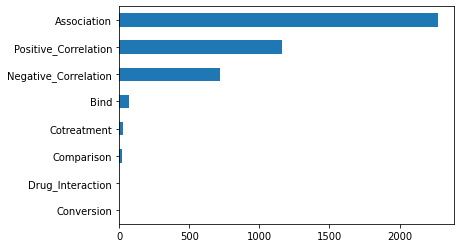

In [15]:
relations_train['type'].value_counts().plot(kind="barh").invert_yaxis()

In [16]:
text_train_EID = pd.read_csv('text_train_LitCoin_EID.txt', sep='\n', header=None)
text_dev_EID = pd.read_csv('text_dev_LitCoin_EID.txt', sep='\n', header=None)
text_train_EID

,0
0,Microinjection of ritanserin into the CA1 regi...
1,The effect of ritanserin ( 5 - HT2 antagonist ...
2,Rats were divided into eight groups and bilate...
3,"One week later , they received repeatedly vehi..."
4,Animals were tested for four consecutive days ...
...,...
3243,The two transversions resulted in the substitu...
3244,The six unaffected family individuals carried ...
3245,These two mutations were not detected in any o...
3246,CONCLUSIONS : Those novel compound heterozygou...


In [17]:
labels_train_IOB = pd.read_csv('labels_train_LitCoin_IOB.txt', sep='\n', header=None)
labels_dev_IOB = pd.read_csv('labels_dev_LitCoin_IOB.txt', sep='\n', header=None)
labels_train_IOB

,0
0,O O B-ChemicalEntity O O O O O O O B-ChemicalE...
1,O O O B-ChemicalEntity O B-GeneOrGeneProduct O...
2,B-OrganismTaxon O O O O O O O O O O O O O O O
3,O O O O O O O O O O O B-ChemicalEntity O O O B...
4,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...
3243,O O O O O O O O O B-SequenceVariant I-Sequence...
3244,O O O O O O O O O O
3245,O O O O O O O O O O O O O O
3246,O O O O O O O O O O O O O O O B-GeneOrGeneProd...


In [18]:
labels_train_EID = pd.read_csv('labels_train_LitCoin_EID.txt', sep='\n', header=None)
labels_dev_EID = pd.read_csv('labels_dev_LitCoin_EID.txt', sep='\n', header=None)
labels_train_EID

,0
0,O O D016713 O O O O O O O D012601 O O D000647 ...
1,O O O D016713 O 29595 O 29595 O O O D012601 O ...
2,10116 O O O O O O O O O O O O O O O
3,O O O O O O O O O O O D004121 O O O D004121 O ...
4,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...
3243,O O O O O O O O O p|SUB|Q|298|X p|SUB|Q|298|X ...
3244,O O O O O O O O O O
3245,O O O O O O O O O O O O O O
3246,O O O O O O O O O O O O O O O 4166 O O O O O O...


In [19]:
labels_train_AID = pd.read_csv('labels_train_LitCoin_AID.txt', sep='\n', header=None)
labels_dev_AID = pd.read_csv('labels_dev_LitCoin_AID.txt', sep='\n', header=None)
labels_train_AID

,0
0,16364460 16364460 16364460 16364460 16364460 1...
1,16364460 16364460 16364460 16364460 16364460 1...
2,16364460 16364460 16364460 16364460 16364460 1...
3,16364460 16364460 16364460 16364460 16364460 1...
4,16364460 16364460 16364460 16364460 16364460 1...
...,...
3243,19365571 19365571 19365571 19365571 19365571 1...
3244,19365571 19365571 19365571 19365571 19365571 1...
3245,19365571 19365571 19365571 19365571 19365571 1...
3246,19365571 19365571 19365571 19365571 19365571 1...


In [20]:
REL_LABEL_DIC = {'Association':1, 'Positive_Correlation':2,
                 'Negative_Correlation':3, 'Bind':4, 'Cotreatment':5,
                 'Comparison':6, 'Drug_Interaction':7, 'Conversion':8}

In [26]:
entire_text_idx = 0
x = []
y = []

# while entire_text_idx < len(text_train_EID):
while entire_text_idx < len(text_dev_EID):
    # text = text_train_EID[0].iloc[entire_text_idx]
    # EID = labels_train_EID[0].iloc[entire_text_idx]
    # IOB = labels_train_IOB[0].iloc[entire_text_idx]
    text = text_dev_EID[0].iloc[entire_text_idx]
    EID = labels_dev_EID[0].iloc[entire_text_idx]
    IOB = labels_dev_IOB[0].iloc[entire_text_idx]
    
    text_list = text.split()
    EID_list = EID.split()
    IOB_list = IOB.split()
    
    # abstract_id = int(labels_train_AID[0].iloc[entire_text_idx].split()[0])
    abstract_id = int(labels_dev_AID[0].iloc[entire_text_idx].split()[0])
    relations = relations_train[relations_train['abstract_id'] == abstract_id]
    entity_list = relations[['entity_1_id', 'entity_2_id']].values.tolist()
    
    IOB_idx_list = []
    count = 0
    for idx in range(len(IOB_list)):
        if IOB_list[idx] != 'O':
            if 'B-' in IOB_list[idx]:
                IOB_idx_list.append(idx)
                if count == 0:
                    count += 1
                else:
                    count = 1
            else:
                if count == 1:
                    IOB_idx_list[len(IOB_idx_list) - 1] = [IOB_idx_list[len(IOB_idx_list) - 1], idx]
                    count += 1
                elif count >= 1:
                    IOB_idx_list[len(IOB_idx_list) - 1].append(idx)
    
    combination_idx_list = []
    for idx in range(len(IOB_idx_list) - 1):
        tmp_list = IOB_idx_list[idx + 1:]
        for i in tmp_list:
            combination_idx_list.append([IOB_idx_list[idx], i])
    
    for comb_idx in combination_idx_list:
        match_count = 0
        for entity in entity_list:
            if type(comb_idx[0]) == list and type(comb_idx[1]) == list:
                if EID_list[comb_idx[0][0]] == entity[0] and EID_list[comb_idx[1][0]] == entity[1]:
                    tmp_text_list = copy.deepcopy(text_list)
                    for i in IOB_idx_list:
                        if type(i) == list:
                            for j in i:
                                tmp_text_list[j] = 'LCOTHER'
                        else:
                            tmp_text_list[i] = 'LCOTHER'

                    for i in comb_idx[0]:
                        tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
                    for i in comb_idx[1]:
                        tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')

                    x.append(' '.join(tmp_text_list))
                    y.append(REL_LABEL_DIC[relations['type'].iloc[entity_list.index(entity)]])
                    match_count = 1
                    break
            elif type(comb_idx[0]) == int and type(comb_idx[1]) == list:
                if EID_list[comb_idx[0]] == entity[0] and EID_list[comb_idx[1][0]] == entity[1]:
                    tmp_text_list = copy.deepcopy(text_list)
                    for i in IOB_idx_list:
                        if type(i) == list:
                            for j in i:
                                tmp_text_list[j] = 'LCOTHER'
                        else:
                            tmp_text_list[i] = 'LCOTHER'

                    tmp_text_list[comb_idx[0]] = IOB_list[comb_idx[0]].replace('B-', 'LC').replace('I-', 'LC')
                    for i in comb_idx[1]:
                        tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')

                    x.append(' '.join(tmp_text_list))
                    y.append(REL_LABEL_DIC[relations['type'].iloc[entity_list.index(entity)]])
                    match_count = 1
                    break
            elif type(comb_idx[0]) == list and type(comb_idx[1]) == int:
                if EID_list[comb_idx[0][0]] == entity[0] and EID_list[comb_idx[1]] == entity[1]:
                    tmp_text_list = copy.deepcopy(text_list)
                    for i in IOB_idx_list:
                        if type(i) == list:
                            for j in i:
                                tmp_text_list[j] = 'LCOTHER'
                        else:
                            tmp_text_list[i] = 'LCOTHER'

                    for i in comb_idx[0]:
                        tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
                    tmp_text_list[comb_idx[1]] = IOB_list[comb_idx[1]].replace('B-', 'LC').replace('I-', 'LC')

                    x.append(' '.join(tmp_text_list))
                    y.append(REL_LABEL_DIC[relations['type'].iloc[entity_list.index(entity)]])
                    match_count = 1
                    break
            else:
                if EID_list[comb_idx[0]] == entity[0] and EID_list[comb_idx[1]] == entity[1]:
                    tmp_text_list = copy.deepcopy(text_list)
                    for i in IOB_idx_list:
                        if type(i) == list:
                            for j in i:
                                tmp_text_list[j] = 'LCOTHER'
                        else:
                            tmp_text_list[i] = 'LCOTHER'

                    tmp_text_list[comb_idx[0]] = IOB_list[comb_idx[0]].replace('B-', 'LC').replace('I-', 'LC')
                    tmp_text_list[comb_idx[1]] = IOB_list[comb_idx[1]].replace('B-', 'LC').replace('I-', 'LC')
                    
                    x.append(' '.join(tmp_text_list))
                    y.append(REL_LABEL_DIC[relations['type'].iloc[entity_list.index(entity)]])
                    match_count = 1
                    break
    
        if match_count == 1:
            match_count = 0
        else:
            if type(comb_idx[0]) == list and type(comb_idx[1]) == list:
                tmp_text_list = copy.deepcopy(text_list)
                for i in IOB_idx_list:
                    if type(i) == list:
                        for j in i:
                            tmp_text_list[j] = 'LCOTHER'
                    else:
                        tmp_text_list[i] = 'LCOTHER'

                for i in comb_idx[0]:
                    tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
                for i in comb_idx[1]:
                    tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
            elif type(comb_idx[0]) == int and type(comb_idx[1]) == list:
                tmp_text_list = copy.deepcopy(text_list)
                for i in IOB_idx_list:
                    if type(i) == list:
                        for j in i:
                            tmp_text_list[j] = 'LCOTHER'
                    else:
                        tmp_text_list[i] = 'LCOTHER'

                tmp_text_list[comb_idx[0]] = IOB_list[comb_idx[0]].replace('B-', 'LC').replace('I-', 'LC')
                for i in comb_idx[1]:
                    tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
            elif type(comb_idx[0]) == list and type(comb_idx[1]) == int:
                tmp_text_list = copy.deepcopy(text_list)
                for i in IOB_idx_list:
                    if type(i) == list:
                        for j in i:
                            tmp_text_list[j] = 'LCOTHER'
                    else:
                        tmp_text_list[i] = 'LCOTHER'

                for i in comb_idx[0]:
                    tmp_text_list[i] = IOB_list[i].replace('B-', 'LC').replace('I-', 'LC')
                tmp_text_list[comb_idx[1]] = IOB_list[comb_idx[1]].replace('B-', 'LC').replace('I-', 'LC')
            else:
                tmp_text_list = copy.deepcopy(text_list)
                for i in IOB_idx_list:
                    if type(i) == list:
                        for j in i:
                            tmp_text_list[j] = 'LCOTHER'
                    else:
                        tmp_text_list[i] = 'LCOTHER'

                tmp_text_list[comb_idx[0]] = IOB_list[comb_idx[0]].replace('B-', 'LC').replace('I-', 'LC')
                tmp_text_list[comb_idx[1]] = IOB_list[comb_idx[1]].replace('B-', 'LC').replace('I-', 'LC')

            x.append(' '.join(tmp_text_list))
            y.append(0)
    
    entire_text_idx += 1

In [27]:
output = pd.DataFrame({'x':x, 'y':y})
output = pd.concat([output[output['y'] != 0], output[output['y'] == 0].sample(len(output[output['y'] == 1]))])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(output)
output

,x,y
1,Altered replication timing of the LCGeneOrGene...,1
2,Altered replication timing of the LCOTHER / LC...,1
11,"In this study , we show that the candidate gen...",1
12,"In this study , we show that the candidate gen...",1
13,"In this study , we show that the candidate gen...",1
...,...,...
836,LCOrganismTaxon ovarian germline stem cells ( ...,0
1746,LCOTHER - induced LCOTHER LCOTHER included inc...,0
3982,We genotyped candidate single - nucleotide pol...,0
3618,We conclude that the SNPs of LCGeneOrGeneProdu...,0


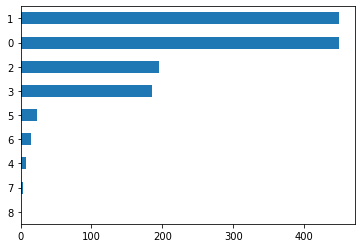

In [28]:
output['y'].value_counts().plot(kind="barh").invert_yaxis()

In [29]:
# output.to_csv('train_LitCoin_RE.tsv', index=False, header=False, sep='\t')
output.to_csv('dev_LitCoin_RE.tsv', index=False, header=False, sep='\t')

# RE

In [2]:
BRANCH = 'r1.4.0'
MODEL_CONFIG = 'text_classification_config.yaml'

if not os.path.exists(MODEL_CONFIG):
    print('Downloading config file...')
    wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/text_classification/conf/' + MODEL_CONFIG, './')
else:
    print ('config file is already exists')

config file is already exists


In [3]:
config = OmegaConf.load(f'{MODEL_CONFIG}')

In [4]:
config.model.train_ds.file_path = 'train_LitCoin_RE.tsv'
config.model.validation_ds.file_path = 'dev_LitCoin_RE.tsv'
# Note: these are small batch-sizes - increase as appropriate to available GPU capacity
config.model.train_ds.batch_size = 24
config.model.validation_ds.batch_size = 24
config.model.dataset.num_classes = 9
config.model.max_seq_length = -1
config.trainer.max_epochs = 10

In [5]:
print(OmegaConf.to_yaml(config))

trainer:
  gpus: 1
  num_nodes: 1
  max_epochs: 10
  max_steps: null
  accumulate_grad_batches: 1
  gradient_clip_val: 0.0
  amp_level: O0
  precision: 32
  accelerator: ddp
  log_every_n_steps: 1
  val_check_interval: 1.0
  resume_from_checkpoint: null
  num_sanity_val_steps: 0
  checkpoint_callback: false
  logger: false
model:
  nemo_path: text_classification_model.nemo
  tokenizer:
    tokenizer_name: ${model.language_model.pretrained_model_name}
    vocab_file: null
    tokenizer_model: null
    special_tokens: null
  language_model:
    pretrained_model_name: bert-base-uncased
    lm_checkpoint: null
    config_file: null
    config: null
  classifier_head:
    num_output_layers: 2
    fc_dropout: 0.1
  class_labels:
    class_labels_file: null
  dataset:
    num_classes: 9
    do_lower_case: false
    max_seq_length: 256
    class_balancing: null
    use_cache: false
  train_ds:
    file_path: train_LitCoin_RE.tsv
    batch_size: 24
    shuffle: true
    num_samples: -1
    num_

In [6]:
# lets modify some trainer configs
# checks if we have GPU available and uses it
cuda = 1 if torch.cuda.is_available() else 0
config.trainer.gpus = cuda

# for PyTorch Native AMP set precision=16
config.trainer.precision = 16 if torch.cuda.is_available() else 32

# remove distributed training flags
config.trainer.accelerator = None

trainer = pl.Trainer(**config.trainer)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
exp_dir = exp_manager(trainer, config.get("exp_manager", None))

# the exp_dir provides a path to the current experiment for easy access
exp_dir = str(exp_dir)
exp_dir

[NeMo I 2022-02-07 16:18:29 exp_manager:220] Experiments will be logged at /workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29
[NeMo I 2022-02-07 16:18:29 exp_manager:569] TensorboardLogger has been set up


[NeMo W 2022-02-07 16:18:29 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:240: LightningDeprecationWarning: `ModelCheckpoint(every_n_val_epochs)` is deprecated in v1.4 and will be removed in v1.6. Please use `every_n_epochs` instead.
      rank_zero_deprecation(
    


'/workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29'

In [8]:
# complete list of supported BERT-like models
print(nemo_nlp.modules.get_pretrained_lm_models_list())

# specify BERT-like model, you want to use, for example, "megatron-bert-345m-uncased" or 'bert-base-uncased'
PRETRAINED_BERT_MODEL = "biomegatron-bert-345m-cased"

['megatron-bert-345m-uncased', 'megatron-bert-345m-cased', 'megatron-bert-uncased', 'megatron-bert-cased', 'biomegatron-bert-345m-uncased', 'biomegatron-bert-345m-cased', 'bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'cl-tohoku/bert-base-japanese', 'cl-tohoku/bert-base-japanese-whole-word-masking', 'cl-tohoku/bert-base-japanese-char', 'cl-tohoku/bert-base-japanese-char-whole-word-masking', 'TurkuNLP/bert-base-finnish-cased-v1', 'TurkuNLP/bert-base-finnish-uncased-v1', 'wietsedv/bert-base-dutch-cased', 'distilbert-base-uncased', 'distilbert-base-uncased-

In [9]:
# add the specified above model parameters to the config
config.model.language_model.pretrained_model_name = PRETRAINED_BERT_MODEL

In [10]:
model = nemo_nlp.models.TextClassificationModel(cfg=config.model, trainer=trainer)

[NeMo I 2022-02-07 16:18:33 tokenizer_utils:100] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /root/.cache/torch/megatron/biomegatron-bert-345m-cased_vocab, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2022-02-07 16:18:36 text_classification_dataset:120] Read 6463 examples from train_LitCoin_RE.tsv.
[NeMo I 2022-02-07 16:18:36 text_classification_dataset:238] *** Example ***
[NeMo I 2022-02-07 16:18:36 text_classification_dataset:239] example 0: ['LCOTHER', 'AND', 'METHODS', ':', 'We', 'examined', '102', 'LCOrganismTaxon', '(', 'LCOTHER', '/', 'LCOTHER', ',', '40', '/', '62', ';', 'median', 'age', ',', '42', ')', 'diagnosed', 'with', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', 'and', '188', 'healthy', 'controls', '(', 'LCOTHER', '/', 'LCOTHER', ',', '78', '/', '110', ';', 'median', 'age', ',', '38', ')', '.']
[NeMo I 2022-02-07 16:18:36 text_classification_dataset:240] subtokens: [CLS] L ##CO ##TH ##ER AND ME ##TH ##OD ##S : We examined 102 L ##CO ##rgan ##ism ##T ##ax ##on ( L ##CO ##TH ##ER / L ##CO ##TH ##ER , 40 / 62 ; median age , 42 ) diagnosed with L ##CD ##ise ##ase ##O ##r ##P ##hen ##otypic ##F ##eat ##ure L ##CD ##ise ##ase ##O ##r ##P ##hen ##o

[NeMo W 2022-02-07 16:18:50 text_classification_dataset:250] Found 139 out of 6463 sentences with more than 256 subtokens. Truncated long sentences from the end.


[NeMo I 2022-02-07 16:18:50 data_preprocessing:358] Some stats of the lengths of the sequences:
[NeMo I 2022-02-07 16:18:50 data_preprocessing:360] Min: 28 |                  Max: 257 |                  Mean: 107.23178090669967 |                  Median: 99.0
[NeMo I 2022-02-07 16:18:50 data_preprocessing:366] 75 percentile: 131.00
[NeMo I 2022-02-07 16:18:50 data_preprocessing:367] 99 percentile: 257.00
[NeMo I 2022-02-07 16:18:50 text_classification_dataset:120] Read 1332 examples from dev_LitCoin_RE.tsv.
[NeMo I 2022-02-07 16:18:52 text_classification_dataset:238] *** Example ***
[NeMo I 2022-02-07 16:18:52 text_classification_dataset:239] example 0: ['Altered', 'replication', 'timing', 'of', 'the', 'LCGeneOrGeneProduct', '/', 'LCOTHER', 'locus', 'in', 'the', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', '.']
[NeMo I 2022-02-07 16:18:52 text_classification_dataset:240] subtokens: [CLS] Alt ##ered repli

[NeMo W 2022-02-07 16:18:55 text_classification_dataset:250] Found 42 out of 1332 sentences with more than 256 subtokens. Truncated long sentences from the end.


[NeMo I 2022-02-07 16:18:55 data_preprocessing:358] Some stats of the lengths of the sequences:
[NeMo I 2022-02-07 16:18:55 data_preprocessing:360] Min: 34 |                  Max: 257 |                  Mean: 105.70345345345345 |                  Median: 94.0
[NeMo I 2022-02-07 16:18:55 data_preprocessing:366] 75 percentile: 135.00
[NeMo I 2022-02-07 16:18:55 data_preprocessing:367] 99 percentile: 257.00
[NeMo I 2022-02-07 16:18:55 text_classification_model:216] Dataloader config or file_path for the test is missing, so no data loader for test is created!


[NeMo W 2022-02-07 16:18:55 modelPT:197] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


using world size: 1, data-parallel-size: 1, tensor-model-parallel size: 1, pipeline-model-parallel size: 1 
setting global batch size to 1
using torch.float32 for parameters ...
------------------------ arguments ------------------------
  adam_beta1 ...................................... 0.9
  adam_beta2 ...................................... 0.999
  adam_eps ........................................ 1e-08
  adlr_autoresume ................................. False
  adlr_autoresume_interval ........................ 1000
  apply_query_key_layer_scaling ................... True
  apply_residual_connection_post_layernorm ........ False
  attention_dropout ............................... 0.1
  attention_softmax_in_fp32 ....................... False
  bert_load ....................................... None
  bias_dropout_fusion ............................. False
  bias_gelu_fusion ................................ False
  block_data_path ................................. None
  checkpoint_act

[NeMo W 2022-02-07 16:19:14 megatron_bert:204] Megatron-lm checkpoint version not found. Setting checkpoint_version to 0.


[NeMo I 2022-02-07 16:19:14 megatron_bert:212] Checkpoint loaded from from /root/.cache/torch/megatron/biomegatron-bert-345m-cased


In [11]:
# start model training
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-02-07 16:19:17 modelPT:544] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.999]
        eps: 1e-08
        lr: 2e-05
        weight_decay: 0.01
    )
[NeMo I 2022-02-07 16:19:17 lr_scheduler:621] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7f3b2c993dc0>" 
    will be used during training (effective maximum steps = 2700) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 2700
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | loss                  | CrossEntropyLoss     | 0     
1 | bert_model            | MegatronBertEncoder  | 332 M 
2 | classifier            | SequenceClassifier   | 1.1 M 
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
333 M     Trainable params
0         Non-trainable params
333 M     Total params
1,334.600 Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

> initializing torch distributed ...


I0207 16:19:18.206082 139895264646976 distributed_c10d.py:214] Added key: store_based_barrier_key:1 to store for rank: 0
I0207 16:19:18.207275 139895264646976 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.
I0207 16:19:18.208539 139895264646976 distributed_c10d.py:214] Added key: store_based_barrier_key:2 to store for rank: 0
I0207 16:19:18.209140 139895264646976 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:2 with 1 nodes.
I0207 16:19:18.209896 139895264646976 distributed_c10d.py:214] Added key: store_based_barrier_key:3 to store for rank: 0
I0207 16:19:18.210612 139895264646976 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:3 with 1 nodes.
I0207 16:19:18.211476 139895264646976 distributed_c10d.py:214] Added key: store_based_barrier_key:4 to store for rank: 0
I0207 16:19:18.212138 139895264646976 distributed_c10d.py:248] Rank 0

> initializing tensor model parallel with size 1
> initializing pipeline model parallel with size 1
> setting random seeds to 1234 ...
> initializing model parallel cuda seeds on global rank 0, model parallel rank 0, and data parallel rank 0 with model parallel seed: 3952 and data parallel seed: 1234


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:21:54 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             65.99      72.44      69.07        450
    label_id: 1                                             60.73      74.22      66.80        450
    label_id: 2                                             49.55      56.12      52.63        196
    label_id: 3                                             57.58      20.43      30.16        186
    label_id: 4                                              0.00       0.00       0.00          7
    label_id: 5                                              0.00       0.00       0.00         23
    label_id: 6                                              0.00       0.00       0.00         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 0, global step 269: val_loss reached 1.10207 (best 1.10207), saving model to "/workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29/checkpoints/TextClassification--val_loss=1.1021-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:25:55 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             90.42      71.33      79.75        450
    label_id: 1                                             68.78      72.44      70.56        450
    label_id: 2                                             47.49      72.45      57.37        196
    label_id: 3                                             54.79      55.38      55.08        186
    label_id: 4                                              0.00       0.00       0.00          7
    label_id: 5                                              0.00       0.00       0.00         23
    label_id: 6                                             50.00      53.33      51.61         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 1, global step 539: val_loss reached 0.89677 (best 0.89677), saving model to "/workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29/checkpoints/TextClassification--val_loss=0.8968-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:29:50 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             82.31      77.56      79.86        450
    label_id: 1                                             76.44      56.22      64.79        450
    label_id: 2                                             41.65      85.20      55.95        196
    label_id: 3                                             66.43      50.00      57.06        186
    label_id: 4                                              0.00       0.00       0.00          7
    label_id: 5                                              0.00       0.00       0.00         23
    label_id: 6                                             37.50      80.00      51.06         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 2, global step 809: val_loss reached 0.96523 (best 0.89677), saving model to "/workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29/checkpoints/TextClassification--val_loss=0.9652-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:33:25 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             82.53      84.00      83.26        450
    label_id: 1                                             74.06      65.33      69.42        450
    label_id: 2                                             50.84      77.04      61.26        196
    label_id: 3                                             71.74      53.23      61.11        186
    label_id: 4                                             20.00      14.29      16.67          7
    label_id: 5                                              0.00       0.00       0.00         23
    label_id: 6                                             40.54     100.00      57.69         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 3, global step 1079: val_loss reached 0.90554 (best 0.89677), saving model to "/workspace/nemo/nemo_experiments/TextClassification/2022-02-07_16-18-29/checkpoints/TextClassification--val_loss=0.9055-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:37:18 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             80.83      82.44      81.63        450
    label_id: 1                                             67.40      74.89      70.95        450
    label_id: 2                                             59.19      67.35      63.01        196
    label_id: 3                                             75.23      44.09      55.59        186
    label_id: 4                                              0.00       0.00       0.00          7
    label_id: 5                                            100.00       8.70      16.00         23
    label_id: 6                                             39.47     100.00      56.60         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 4, global step 1349: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:40:12 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             82.33      81.78      82.05        450
    label_id: 1                                             72.11      70.67      71.38        450
    label_id: 2                                             52.94      68.88      59.87        196
    label_id: 3                                             68.35      58.06      62.79        186
    label_id: 4                                             33.33      14.29      20.00          7
    label_id: 5                                             83.33      21.74      34.48         23
    label_id: 6                                             50.00      73.33      59.46         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 5, global step 1619: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:43:01 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             87.11      75.11      80.67        450
    label_id: 1                                             72.54      64.00      68.00        450
    label_id: 2                                             50.17      74.49      59.96        196
    label_id: 3                                             58.02      66.13      61.81        186
    label_id: 4                                             14.29      14.29      14.29          7
    label_id: 5                                             53.33      34.78      42.11         23
    label_id: 6                                             40.91      60.00      48.65         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 6, global step 1889: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:45:54 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             84.76      81.56      83.13        450
    label_id: 1                                             74.62      64.67      69.29        450
    label_id: 2                                             52.55      73.47      61.28        196
    label_id: 3                                             63.68      65.05      64.36        186
    label_id: 4                                             16.67      14.29      15.38          7
    label_id: 5                                             75.00      26.09      38.71         23
    label_id: 6                                             41.94      86.67      56.52         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 7, global step 2159: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:48:54 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             82.33      81.78      82.05        450
    label_id: 1                                             73.77      63.11      68.02        450
    label_id: 2                                             52.65      70.92      60.43        196
    label_id: 3                                             60.41      63.98      62.14        186
    label_id: 4                                             28.57      28.57      28.57          7
    label_id: 5                                             57.14      34.78      43.24         23
    label_id: 6                                             50.00      60.00      54.55         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 8, global step 2429: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:51:43 text_classification_model:165] val_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             84.85      80.89      82.82        450
    label_id: 1                                             72.95      67.11      69.91        450
    label_id: 2                                             53.33      73.47      61.80        196
    label_id: 3                                             64.64      62.90      63.76        186
    label_id: 4                                             16.67      14.29      15.38          7
    label_id: 5                                             50.00      26.09      34.29         23
    label_id: 6                                             45.00      60.00      51.43         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8              

Epoch 9, global step 2699: val_loss was not in top 3


In [12]:
eval_config = OmegaConf.create(
    {'file_path': './dev_LitCoin_RE.tsv', 'batch_size': 24, 'shuffle': False, 'num_workers': 3}
)
model.setup_test_data(test_data_config=eval_config)

[NeMo I 2022-02-07 16:53:34 text_classification_dataset:120] Read 1332 examples from ./dev_LitCoin_RE.tsv.
[NeMo I 2022-02-07 16:53:34 text_classification_dataset:238] *** Example ***
[NeMo I 2022-02-07 16:53:34 text_classification_dataset:239] example 0: ['Altered', 'replication', 'timing', 'of', 'the', 'LCGeneOrGeneProduct', '/', 'LCOTHER', 'locus', 'in', 'the', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', 'LCDiseaseOrPhenotypicFeature', '.']
[NeMo I 2022-02-07 16:53:34 text_classification_dataset:240] subtokens: [CLS] Alt ##ered replication timing of the L ##C ##G ##ene ##O ##r ##G ##ene ##P ##rod ##uc ##t / L ##CO ##TH ##ER lo ##cus in the L ##CD ##ise ##ase ##O ##r ##P ##hen ##otypic ##F ##eat ##ure L ##CD ##ise ##ase ##O ##r ##P ##hen ##otypic ##F ##eat ##ure L ##CD ##ise ##ase ##O ##r ##P ##hen ##otypic ##F ##eat ##ure L ##CD ##ise ##ase ##O ##r ##P ##hen ##otypic ##F ##eat ##ure . [SEP]
[NeMo I 2022-02-07 16:53:34 text_classifi

[NeMo W 2022-02-07 16:53:36 text_classification_dataset:250] Found 42 out of 1332 sentences with more than 256 subtokens. Truncated long sentences from the end.


[NeMo I 2022-02-07 16:53:36 data_preprocessing:358] Some stats of the lengths of the sequences:
[NeMo I 2022-02-07 16:53:36 data_preprocessing:360] Min: 34 |                  Max: 257 |                  Mean: 105.70345345345345 |                  Median: 94.0
[NeMo I 2022-02-07 16:53:36 data_preprocessing:366] 75 percentile: 135.00
[NeMo I 2022-02-07 16:53:36 data_preprocessing:367] 99 percentile: 257.00


In [13]:
eval_trainer = pl.Trainer(gpus=1)
model.set_trainer(eval_trainer)
eval_trainer.test(model=model, verbose=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[NeMo I 2022-02-07 16:54:02 text_classification_model:165] test_report: 
    label                                                precision    recall       f1           support   
    label_id: 0                                             85.05      80.89      82.92        450
    label_id: 1                                             73.19      67.33      70.14        450
    label_id: 2                                             53.51      73.98      62.10        196
    label_id: 3                                             64.64      62.90      63.76        186
    label_id: 4                                             16.67      14.29      15.38          7
    label_id: 5                                             50.00      26.09      34.29         23
    label_id: 6                                             45.00      60.00      51.43         15
    label_id: 7                                              0.00       0.00       0.00          4
    label_id: 8             

[{'test_loss': 1.270993709564209,
  'test_precision': 70.9459457397461,
  'test_f1': 70.9459457397461,
  'test_recall': 70.9459457397461}]

In [30]:
dev_LitCoin_RE = pd.read_csv('dev_LitCoin_RE.tsv', sep='\t', header=None)
dev_LitCoin_RE

,0,1
0,Altered replication timing of the LCGeneOrGene...,1
1,Altered replication timing of the LCOTHER / LC...,1
2,"In this study , we show that the candidate gen...",1
3,"In this study , we show that the candidate gen...",1
4,"In this study , we show that the candidate gen...",1
...,...,...
1327,LCOrganismTaxon ovarian germline stem cells ( ...,0
1328,LCOTHER - induced LCOTHER LCOTHER included inc...,0
1329,We genotyped candidate single - nucleotide pol...,0
1330,We conclude that the SNPs of LCGeneOrGeneProdu...,0


In [34]:
# move the model to the desired device for inference
# we move the model to "cuda" if available otherwise "cpu" would be used
if torch.cuda.is_available():
    model.to("cuda")
else:
    model.to("cpu")
    
results = model.classifytext(queries=dev_LitCoin_RE[0].tolist(), batch_size=24)

print('The prediction results of some sample queries with the trained model:')
for query, result in zip(dev_LitCoin_RE[0].tolist(), results):
    print(f'Query : {query}')
    print(f'Predicted label: {result}')

The prediction results of some sample queries with the trained model:
Query : Altered replication timing of the LCGeneOrGeneProduct / LCOTHER locus in the LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature .
Predicted label: 1
Query : Altered replication timing of the LCOTHER / LCGeneOrGeneProduct locus in the LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature LCDiseaseOrPhenotypicFeature .
Predicted label: 1
Query : In this study , we show that the candidate gene LCGeneOrGeneProduct / LCOTHER mapping on the non - deleted TDR22 , in LCDiseaseOrPhenotypicFeature / LCOTHER subjects presents a delayed replication timing .
Predicted label: 1
Query : In this study , we show that the candidate gene LCGeneOrGeneProduct / LCOTHER mapping on the non - deleted TDR22 , in LCOTHER / LCDiseaseOrPhenotypicFeature subjects presents a delayed replication timing .
Predicted label: 1
Query : In this stud

In [41]:
!pip3 install seaborn

from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [42]:
confMatrix = confusion_matrix(dev_LitCoin_RE[1].tolist(), results)
confMatrix = confMatrix / confMatrix.astype(float).sum(axis=0)
confMatrix = np.where(np.isnan(confMatrix), 0, confMatrix)

[NeMo W 2022-02-07 17:22:20 nemo_logging:349] /tmp/ipykernel_2313/3062392924.py:2: RuntimeWarning: invalid value encountered in true_divide
      confMatrix = confMatrix / confMatrix.astype(float).sum(axis=0)
    


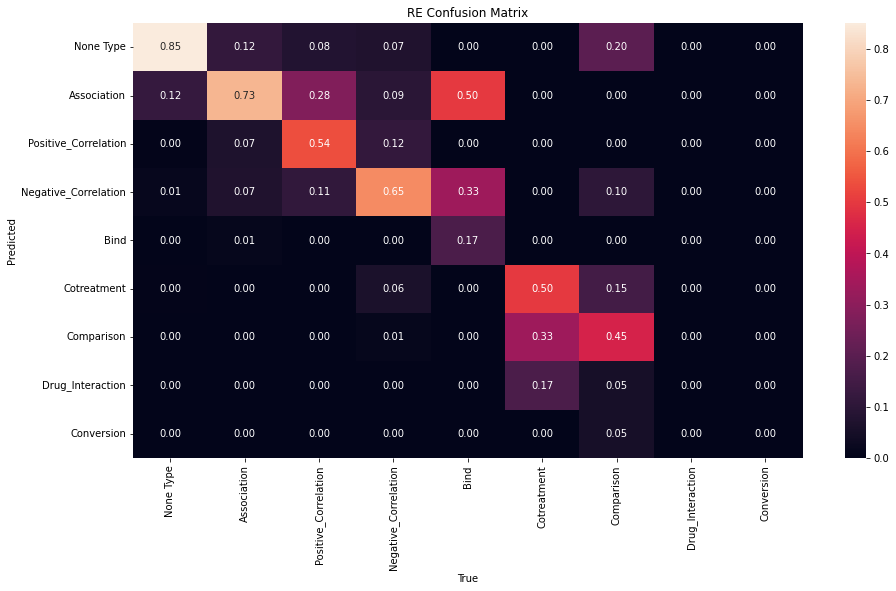

In [43]:
RE_LABELS = ['None Type', 'Association', 'Positive_Correlation',
             'Negative_Correlation', 'Bind', 'Cotreatment',
             'Comparison', 'Drug_Interaction', 'Conversion']

plt.figure(figsize=(15, 8))
ax = sn.heatmap(confMatrix, annot=True, fmt='.2f', xticklabels=RE_LABELS, yticklabels=RE_LABELS)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('RE Confusion Matrix')
plt.show()